In [128]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import numpy as np
import pandas as pd
import verde as vd

In [20]:
columns = {"station_id": str, "time": str, "longitude": float, "latitude": float, "air_temperature_c": float, "wind_direction_north": float, "wind_speed_knots": float}
#korea = pd.read_csv('korea.txt', skiprows=1, dtype=columns, names=columns.keys(), parse_dates=["time"], na_values=["M"], usecols=[0, 1, 2, 3, 4, 5, 6])
#japan = pd.read_csv('japan.txt', skiprows=1, dtype=columns, names=columns.keys(), parse_dates=["time"], na_values=["M"], usecols=[0, 1, 2, 3, 4, 5, 6])
#data = pd.concat([korea, japan], ignore_index=True).dropna()
data = pd.read_csv('texas.txt', skiprows=1, dtype=columns, names=columns.keys(), parse_dates=["time"], na_values=["M"], usecols=[0, 1, 2, 3, 4, 5, 6])
data = data[data.station_id != "VKY"]
data['wind_speed_east_knots'] = np.sin(np.radians(data.wind_direction_north))*data.wind_speed_knots
data['wind_speed_north_knots'] = np.cos(np.radians(data.wind_direction_north))*data.wind_speed_knots
data.head()

,station_id,time,longitude,latitude,air_temperature_c,wind_direction_north,wind_speed_knots,wind_speed_east_knots,wind_speed_north_knots
0,BRO,2018-01-01,-97.4231,25.9146,NaN,360.0,11.0,-2.694223e-15,11.000000
1,AUS,2018-01-01,-97.6699,30.1945,NaN,NaN,NaN,NaN,NaN
2,TPL,2018-01-01,-97.4078,31.1525,NaN,340.0,14.0,-4.788282e+00,13.155697
3,ILE,2018-01-01,-97.6865,31.0858,NaN,360.0,11.0,-2.694223e-15,11.000000
4,LBB,2018-01-01,-101.8228,33.6636,NaN,30.0,10.0,5.000000e+00,8.660254


In [22]:
mean = data.dropna(subset=["wind_direction_north", "wind_speed_knots"]).groupby('station_id').mean()
print(mean.shape, data.station_id.unique().size)
mean.head()

(194, 7) 194


,longitude,latitude,air_temperature_c,wind_direction_north,wind_speed_knots,wind_speed_east_knots,wind_speed_north_knots
station_id,,,,,,,
0F2,-97.7756,33.6017,4.307983,185.229485,7.002318,-0.209707,-0.738854
11R,-96.3742,30.2189,8.690950,158.025035,5.898934,0.155503,1.729400
2F5,-101.9018,32.7479,3.926340,179.048951,9.157110,-0.648198,-2.120885
3T5,-96.9500,29.9100,8.471494,141.651729,5.284251,0.183530,0.981319
5C1,-98.6946,29.7239,6.435611,115.639238,4.557415,0.185699,0.772838


In [216]:
bla = mean.drop(columns=["wind_direction_north", "wind_speed_knots"])
bla.to_csv("data/texas-wind.csv", index_label="station_id", compression=None)

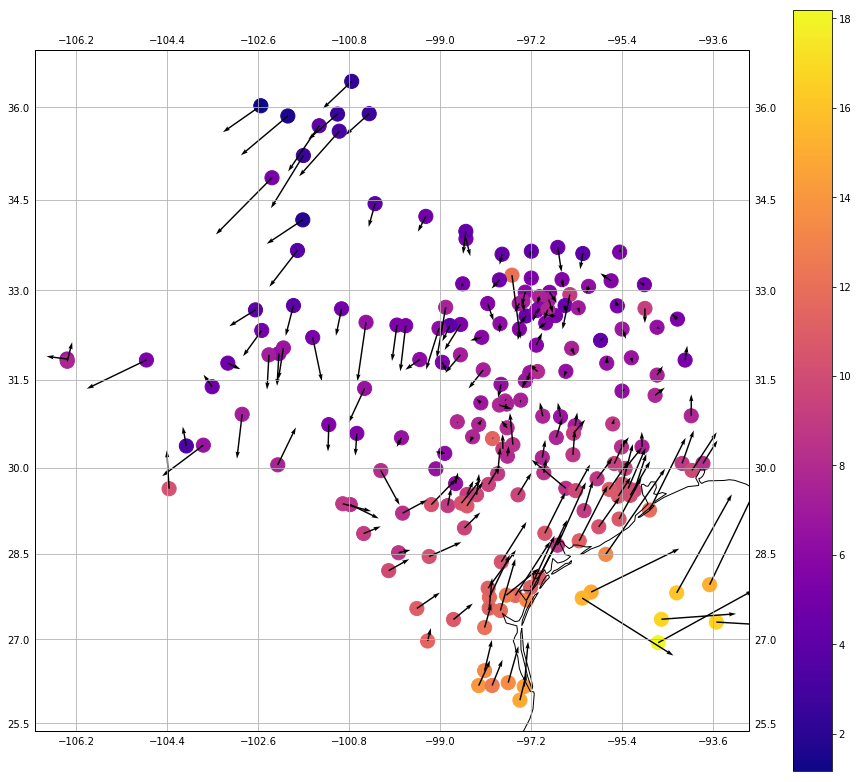

In [23]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(111, projection=ccrs.Mercator())
maxabs = vd.maxabs(mean.air_temperature_c)
tmp = ax.scatter(mean.longitude, mean.latitude, c=mean.air_temperature_c, s=200, cmap="plasma", transform=crs)
plt.colorbar(tmp)
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.002, transform=crs)
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)

In [24]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
proj_coords = projection(mean.longitude.values, mean.latitude.values)
region = vd.get_region((mean.longitude, mean.latitude))

In [25]:
gridder = vd.Chain([
    ("trend", vd.Trend(degree=2)),
    ("spline", vd.Spline(damping=1e-5, fudge=1000e3))
])
print(np.mean(vd.cross_val_score(gridder, proj_coords, mean.air_temperature_c)))
gridder.fit(proj_coords, mean.air_temperature_c)

0.8319281882709314


Chain(steps=[('trend', Trend(degree=2)), ('spline', Spline(damping=1e-05, fudge=1000000.0, region=None, shape=None, spacing=None))])

In [26]:
grid = gridder.grid(spacing=0.1, region=region, projection=projection)
mask = vd.distance_mask((mean.longitude, mean.latitude), maxdist=2, spacing=0.1, region=region)
grid = grid.where(mask)
grid

<xarray.Dataset>
Dimensions:   (easting: 129, northing: 106)
Coordinates:
  * easting   (easting) float64 -106.4 -106.3 -106.2 -106.1 -106.0 -105.9 ...
  * northing  (northing) float64 25.91 26.01 26.11 26.21 26.31 26.41 26.51 ...
Data variables:
    scalars   (northing, easting) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    metadata:  Generated by Chain(steps=[('trend', Trend(degree=2)), ('spline...

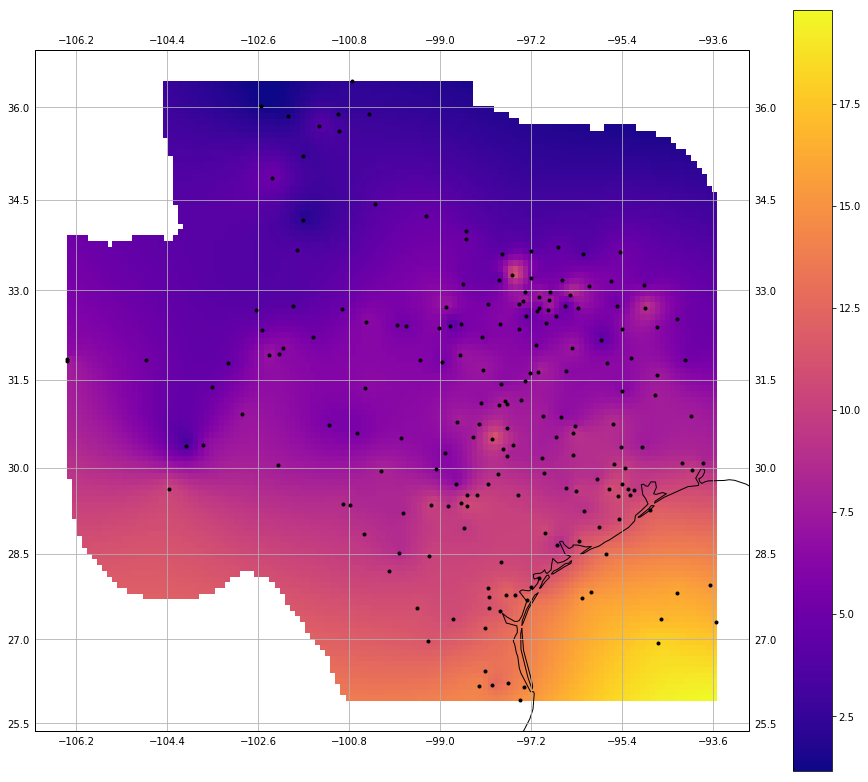

In [27]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(111, projection=ccrs.Mercator())
#maxabs = vd.maxabs(grid.scalars)
tmp = ax.pcolormesh(grid.easting, grid.northing, grid.scalars, cmap="plasma", transform=crs)
plt.colorbar(tmp)
ax.plot(mean.longitude, mean.latitude, ".k", transform=crs)
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)

In [28]:
fit_data = (mean.wind_speed_east_knots, mean.wind_speed_north_knots)

In [205]:
vecgrd = vd.Chain([
    ("trend", vd.Components([vd.Trend(degree=1) for i in range(2)])),
    ('spline', vd.Vector2D(poisson=0.5, damping=1e-10, fudge=500e3))
])
print(np.mean(vd.cross_val_score(vecgrd, proj_coords, fit_data)))
vecgrd.fit(proj_coords, fit_data)

0.6830250070602437


Chain(steps=[('trend', Components(components=[Trend(degree=1), Trend(degree=1)])), ('spline', Vector2D(damping=1e-10, fudge=500000.0, poisson=0.5, region=None, shape=None,
     spacing=None))])

In [206]:
vecgrd2 = vd.Chain([
  #  ("trend", vd.Components([vd.Trend(degree=1) for i in range(2)])),
    #('spline', vd.Components([vd.Spline(damping=1e-15, fudge=100e3) for i in range(2)]))
    ('spline', vd.Components([vd.ScipyGridder() for i in range(2)]))
])
#print(np.mean(vd.cross_val_score(vecgrd2, proj_coords, fit_data)))
vecgrd2.fit(proj_coords, fit_data)

Chain(steps=[('spline', Components(components=[ScipyGridder(extra_args=None, method='cubic'), ScipyGridder(extra_args=None, method='cubic')]))])

In [207]:
spacing = 0.25
mask = vd.distance_mask((mean.longitude, mean.latitude), maxdist=1, spacing=spacing, region=region)
grid = vecgrd.grid(spacing=spacing, region=region, projection=projection).where(mask)
grid2 = vecgrd2.grid(spacing=spacing, region=region, projection=projection).where(mask)
grid

<xarray.Dataset>
Dimensions:          (easting: 52, northing: 43)
Coordinates:
  * easting          (easting) float64 -106.4 -106.1 -105.9 -105.6 -105.4 ...
  * northing         (northing) float64 25.91 26.16 26.41 26.66 26.91 27.16 ...
Data variables:
    east_component   (northing, easting) float64 nan nan nan nan nan nan nan ...
    north_component  (northing, easting) float64 nan nan nan nan nan nan nan ...
Attributes:
    metadata:  Generated by Chain(steps=[('trend', Components(components=[Tre...

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


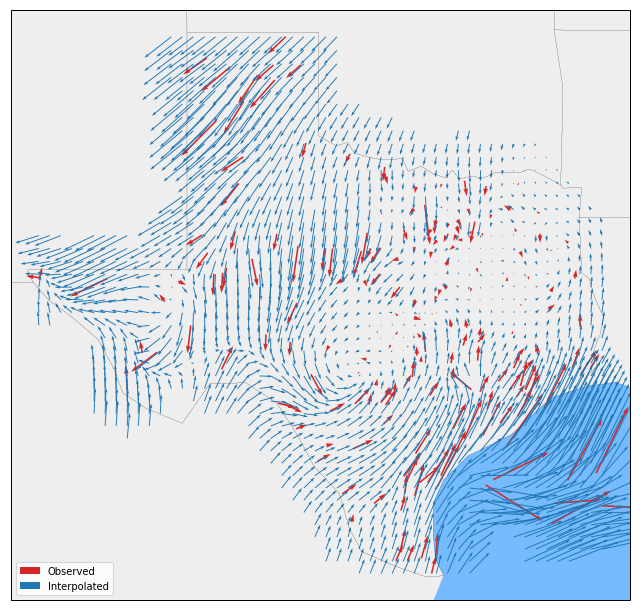

In [211]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(111, projection=ccrs.Mercator())
scale = 70
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.0025, transform=crs, color="tab:red", scale=scale, label="Observed")
ax.quiver(grid.easting.values, grid.northing.values, grid.east_component.values, grid.north_component.values, 
          width=0.0015, transform=crs, scale=scale, color='tab:blue', label="Interpolated")
#ax.coastlines(resolution='50m', linewidth=0.3)
#ax.gridlines(draw_labels=True)
ax.legend(loc="lower left")
ax.add_feature(cfeature.BORDERS, linewidth=0.1)
ax.add_feature(cfeature.STATES, linewidth=0.1)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
ax.add_feature(cfeature.OCEAN, facecolor="xkcd:sky blue")
plt.tight_layout()
fig.savefig("verde-texas-wind-interpolation.png")

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


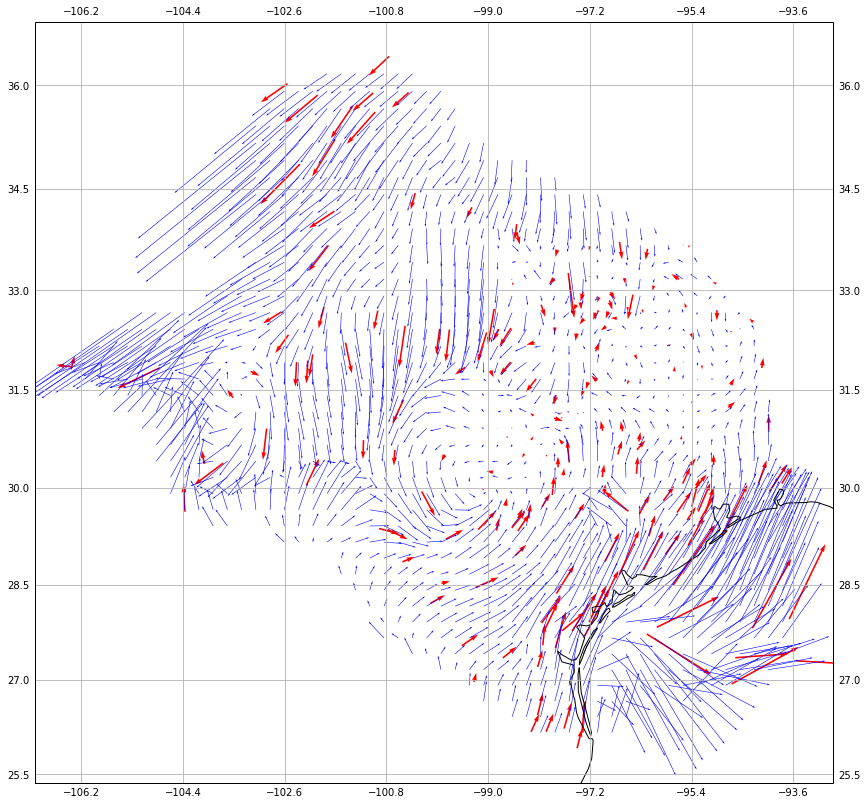

In [204]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(111, projection=ccrs.Mercator())
scale = 80
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.002, transform=crs, color="r", scale=scale)
ax.quiver(grid2.easting.values, grid2.northing.values, grid2.east_component.values, grid2.north_component.values, 
          width=0.0007, transform=crs, scale=scale, color='b')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


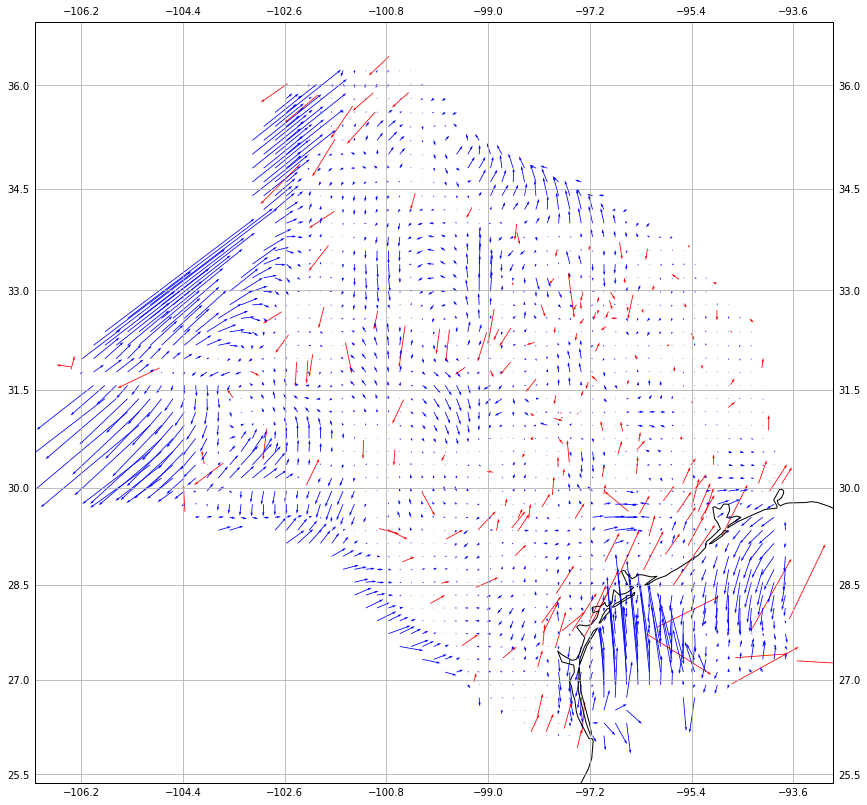

In [123]:
diff = grid - grid2
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(111, projection=ccrs.Mercator())
scale = 80
ax.quiver(mean.longitude.values, mean.latitude.values, mean.wind_speed_east_knots.values, mean.wind_speed_north_knots.values, 
          width=0.001, transform=crs, color="r", scale=scale)
ax.quiver(diff.easting.values, diff.northing.values, diff.east_component.values, diff.north_component.values, 
          width=0.001, transform=crs, scale=scale, color='b')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)